In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from copy import deepcopy as dc

from ssm.lds.models import GaussianLDS
from ssm.inference.smc import smc

In [2]:
# Practice some plotting.
color_names = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple"
]


def plot_true_data(_particles, _data, _i=0):
    fig, axes = plt.subplots(2, 1, sharex=True, squeeze=True)
    axes[0].plot(_particles[_i])
    axes[0].grid(True)
    axes[0].set_ylabel('State')
    
    axes[1].plot(_data[_i])
    axes[1].grid(True)
    axes[1].set_ylabel('Obs')
    
    plt.pause(0.1)
    
    
def plot_sweep(smoothing_particles, true_states, _idx=0, tag=''):

    single_sweep = smoothing_particles[_idx]
    single_true = true_states[_idx]

    single_sweep_median = jnp.median(single_sweep, axis=1)
    single_sweep_lq = jnp.quantile(single_sweep, 0.25, axis=1)
    single_sweep_uq = jnp.quantile(single_sweep, 0.75, axis=1)

    x = range(true_states.shape[1])

    plt.figure()

    for _i, _c in zip(range(single_sweep_median.shape[1]), color_names):
        plt.plot(x, single_sweep_median[:, _i], c=_c)
        plt.fill_between(x, single_sweep_lq[:, _i], single_sweep_uq[:, _i], color=_c)
        plt.plot(single_true[:, _i], c=_c, linestyle='--')

    plt.title(tag)
    plt.grid(True)
    plt.tight_layout()
    plt.pause(0.1)
    

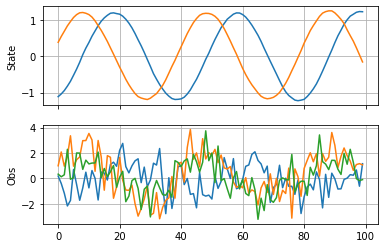

In [4]:
# Define initial PRNG state.
key = jax.random.PRNGKey(1)

# Set up true model.
emissions_dim = 3
latent_dim = 2
key, subkey = jax.random.split(key)
true_model = GaussianLDS(num_latent_dims=latent_dim, num_emission_dims=emissions_dim, seed=subkey)

# Draw some data.
num_trials = 2
num_timesteps = 100
key, subkey = jax.random.split(key)
true_states, observed_data = true_model.sample(key=subkey, num_steps=num_timesteps, num_samples=num_trials)

# Show some data.
plot_true_data(true_states, observed_data, _i=0)

In [ ]:
# Set up the model that we will test with.
test_model = dc(true_model)  # Lets just use the true model for now.

# Do the SMC filtering sweep using BPF.
key, subkey = jax.random.split(key)
smoothing_particles, log_marginal_likelihood, ancestry, filtering_particles = smc(subkey, test_model, observed_data, proposal=None, num_particles=500)

p = 0

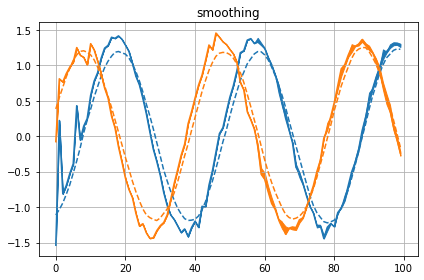

In [6]:
plot_sweep(smoothing_particles, true_states, tag='smoothing')